In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast import StatsForecast

from darts                              import TimeSeries
from darts.models                       import LinearRegressionModel
from darts.dataprocessing.transformers  import Scaler

from sklearn.metrics import mean_squared_error


from mlforecast import MLForecast
from mlforecast.target_transforms import Differences

from sklearn.linear_model import LinearRegression

import lightgbm as lgb
import xgboost  as xgb
from sklearn.ensemble import RandomForestRegressor

C:\Users\ewzbusi\AppData\Roaming\Python\Python310\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def resample_fix_ends(pdf,frequency):
  """
  The function resamples the data according to the sampling frequency. 
  Often the first and the last data-point are deviating a lot from the rest of the series.
  
  As a simple fix i will just delete the first and the last value if they deviate more than 20% to their neighbour. 
  """

  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"

  for column in pdf.columns:
    if pdf[column].iloc[0] < 0.8*pdf[column].iloc[1]:
      pdf = pdf.drop(pdf.index[0]) 
      #pdf.at[pdf.index[0],column]   = pdf[column].iloc[1] #this would assigne the value of the next day to the first day.

    if pdf[column].iloc[-1] < 0.8*pdf[column].iloc[-2]:
      pdf = pdf.drop(pdf.index[-1]) 
      #pdf.at[pdf.index[-1],column]  = pdf[column].iloc[-2] #this would assigne the value of the second last day to the last day.

  return pdf

def reassign_outliers(pdf):
  """There is an extrem outlier in the data which is probably a mistake. I will reassign the value to it's neighbour."""

  for column in pdf.columns:
    
    outlier_loc = np.where(pdf[column] < np.mean(pdf[column])-3*np.std(pdf[column]))
    (pdf[column].values)[outlier_loc] = np.mean(pdf[column]) 

    print(f"Reassigned {len(outlier_loc)} values in the column {column}. These values where more than 3 sigma away from the mean.")

  return pdf


In [3]:
# url = "https://data.stadt-zuerich.ch/dataset/ewz_stromabgabe_netzebenen_stadt_zuerich/download/ewz_stromabgabe_netzebenen_stadt_zuerich.csv"
# pdf = pd.read_csv(url,index_col=None)


pdf = pd.read_csv("../data/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)

pdf["Timestamp"] =  pd.to_datetime(pdf['Timestamp'],utc=True)
pdf = pdf.set_index(pdf["Timestamp"])
pdf = resample_fix_ends(pdf,"D")
pdf = reassign_outliers(pdf)

pdf.index = pdf.index.tz_localize(None)  #Let's drop the timezone info to avoid warnings

pdf["ds"] = pdf.index
pdf["unique_id"] = "test"
pdf = pdf.reset_index(drop=True)

pdf["y"] = (pdf["Value_NE5"].values + pdf["Value_NE7"].values)/1e6
pdf = pdf.drop(columns=["Value_NE5","Value_NE7"])

split = len(pdf)-365
pdf_train, pdf_test = pdf.iloc[:split], pdf.iloc[split:]

pdf

Reassigned 1 values in the column Value_NE5. These values where more than 3 sigma away from the mean.
Reassigned 1 values in the column Value_NE7. These values where more than 3 sigma away from the mean.


C:\Users\ewzbusi\AppData\Local\Temp\ipykernel_16020\3593820342.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"


,ds,unique_id,y
0,2015-01-01,test,6.709087
1,2015-01-02,test,7.073348
2,2015-01-03,test,7.149544
3,2015-01-04,test,6.724467
4,2015-01-05,test,8.585045
...,...,...,...
3087,2023-06-15,test,7.271072
3088,2023-06-16,test,7.173852
3089,2023-06-17,test,6.233946
3090,2023-06-18,test,5.879637


In [4]:
models = [
    LinearRegression(),
    lgb.LGBMRegressor(),
    xgb.XGBRegressor(),
    RandomForestRegressor(random_state=0),
]

mlf = MLForecast(
    models = models,
    lags=[7, 365],
    freq = 'D', 
    date_features=['dayofweek'],
    target_transforms=[Differences([365])]    
)

mlf.fit(pdf_train)


MLForecast(models=[LinearRegression, LGBMRegressor, XGBRegressor, RandomForestRegressor], freq=<Day>, lag_features=['lag7', 'lag365'], date_features=['dayofweek'], num_threads=1)

In [5]:
y_pred = mlf.predict(int(len(pdf_test)))

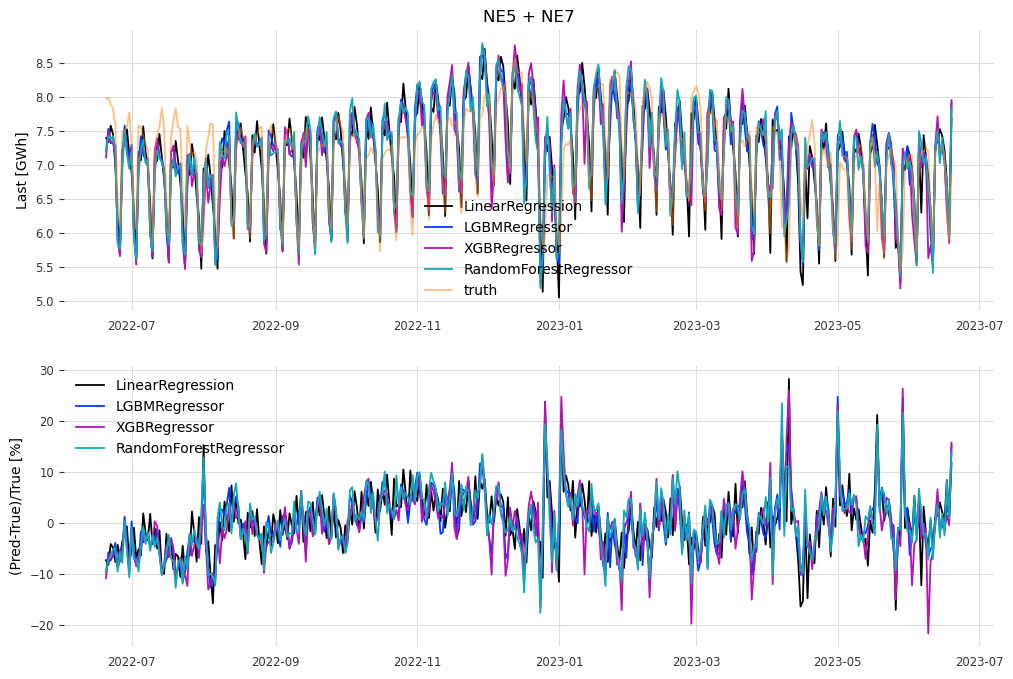

In [6]:
f, axes = plt.subplots(2, 1, figsize=(12, 8))

for name in y_pred.columns[2:]:
    axes[0].plot(y_pred.ds.values, y_pred[name],label=f"{name}")

# axes[0].plot(pdfTrain.ds.values, pdfTrain.y.values, color="tab:blue", label="train")
axes[0].plot(pdf_test.ds.values, pdf_test.y.values, color="tab:orange", label="truth", alpha=0.5)
axes[0].legend()
axes[0].set_title("NE5 + NE7")
axes[0].set_ylabel("Last [GWh]")


xmin, xmax = axes[0].get_xlim()

for name in y_pred.columns[2:]:
    axes[1].plot(pdf_test.ds, ((y_pred[name] - pdf_test.y.values) / (pdf_test.y.values))*100,label=f"{name}")
axes[1].set_xlim(xmin, xmax)
axes[1].set_ylabel("(Pred-True)/True [%]")
axes[1].legend()


plt.show()

In [13]:
for name in y_pred.columns[2:]:
    print(f"RMSE {name}:"+ "{:.3f}".format(mean_squared_error(pdf_test.y.values, y_pred[name].values, squared=False)))

RMSE LinearRegression:0.403
RMSE LGBMRegressor:0.396
RMSE XGBRegressor:0.445
RMSE RandomForestRegressor:0.414
